# Leverage


### Stupidity or genius?

Updated 2020-August-28.


* This notebook looks at what the last 93 years of daily S&P 500 data has to say about the now well-known intra-day leverage.  

* Automatic reinvestment of dividends is assumed. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Constants

In [2]:
# Number of trading days in a year
N_YEAR = 252

# 3x dividends as a fraction of S&P 500 dividends, 
# assumed from the current ratio of UPRO to SPY dividends
DIV3 = 0.15

# Explored leverage space (0% leverage to 100% leverage)
lev = np.linspace(0, 1, 41)


num_years = 10
n_period = num_years * N_YEAR
len_chunk = n_period
len_sep = 1

n_split = N_YEAR
rebalance_idxs = np.arange(n_split, n_period, n_split)

### Load Data

In [3]:
# S&P 500 daily - from Yahoo Finance
df = pd.read_csv('../data/^GSPC.csv', index_col=0, parse_dates=[0])

In [4]:
# S&P 500 annual average dividend - from Quandl
dfi = pd.read_csv('../data/MULTPL-SP500_DIV_YIELD_YEAR-annual.csv', 
                  index_col=0, parse_dates=[0])

dividend_year = dict(zip(dfi.index.year, dfi.Value.to_numpy()))
df['DividendYear'] = df.index.map(lambda x: dividend_year[x.year]) / 100

In [5]:
df

,Open,High,Low,Close,Adj Close,Volume,DividendYear
Date,,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0,0.0441
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0,0.0367
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0,0.0367
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0,0.0367
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0,0.0367
...,...,...,...,...,...,...,...
2020-08-24,3418.090088,3432.090088,3413.129883,3431.280029,3431.280029,3728690000,0.0182
2020-08-25,3435.949951,3444.209961,3425.840088,3443.620117,3443.620117,3619300000,0.0182
2020-08-26,3449.969971,3481.070068,3444.149902,3478.729980,3478.729980,3754360000,0.0182


### Create Daily Leverage

In [6]:
dl = (df.Close / df.Close.shift()).iloc[1:]

dl3 = 3*(dl-1) + 1

In [7]:
div = df.DividendYear.iloc[1:]

Each entry of `dl` is the end of day multiple of the previous trading day's closing price, such that 1.05 would indicate a 5% increase. 

## All n-Year periods since 1927

We assume annual (252 trading days) rebalancing of leverage percentages. 

#### Get the index architecture

In [8]:
assert dl.size == dl3.size

In [9]:
%%time
n_arrays = np.int(np.ceil((dl.size - len_chunk + 1) / len_sep))

rows = np.array((np.arange(n_arrays).reshape(n_arrays, -1) + np.tile(
                np.zeros(len_chunk), n_arrays).reshape(n_arrays, -1)), dtype=np.intp)
columns = np.array(((len_sep*np.arange(0, n_arrays)).reshape(n_arrays, -1) + np.tile(
                np.arange(0, len_chunk), n_arrays).reshape(n_arrays, -1)), dtype=np.intp)

CPU times: user 752 ms, sys: 685 ms, total: 1.44 s
Wall time: 1.44 s


In [10]:
n_arrays

20756

#### Get the start dates

In [11]:
start_dates = dl.index[:n_arrays:len_sep]

#### Get the periods

In [12]:
def get_periods(array):
    return np.tile(array, n_arrays).reshape(n_arrays, -1)[rows, columns]

In [13]:
%%time
dlm = get_periods(dl.to_numpy())

CPU times: user 1.45 s, sys: 1.35 s, total: 2.8 s
Wall time: 2.82 s


In [14]:
%%time 
dlm3 = get_periods(dl3.to_numpy())

CPU times: user 1.43 s, sys: 1.3 s, total: 2.73 s
Wall time: 2.76 s


#### Combine with Dividend Data

In [15]:
%%time
divm = get_periods(div.to_numpy())

CPU times: user 1.38 s, sys: 1.23 s, total: 2.61 s
Wall time: 2.66 s


In [16]:
print(dlm.shape)
assert dlm.shape == dlm3.shape == divm.shape
assert dlm.shape[0] == n_arrays

(20756, 2520)


In [17]:
divmsplit = np.array(np.hsplit(divm, rebalance_idxs)).T

divmsplit = np.average(divmsplit, axis=0)

divmsplit3 = divmsplit * DIV3

#### Get returns from each year

In [18]:
%%time
dlmsplit = np.array(np.hsplit(dlm, rebalance_idxs)).T
dlmsplit = np.product(dlmsplit, axis=0)
dlmsplit += divmsplit

CPU times: user 228 ms, sys: 118 ms, total: 346 ms
Wall time: 345 ms


In [19]:
%%time
dlmsplit3 = np.array(np.hsplit(dlm3, rebalance_idxs)).T
dlmsplit3 = np.product(dlmsplit3, axis=0)
dlmsplit3 += divmsplit3

CPU times: user 246 ms, sys: 131 ms, total: 377 ms
Wall time: 376 ms


#### Aggregate the results over the n-years with varying leverage rates

In [20]:
agg3 = (1-lev).reshape(-1, 1, 1)*dlmsplit + lev.reshape(-1, 1, 1)*dlmsplit3

results3 = np.product(agg3.T, axis=0)

In [21]:
print(results3.shape)

(20756, 41)


#### Get results relative to baseline (S&P 500)

In [22]:
relative3 = results3 / results3[:,0].reshape(n_arrays, -1)

#### Plot many leverage curves

CPU times: user 8.77 s, sys: 132 ms, total: 8.9 s
Wall time: 8.89 s


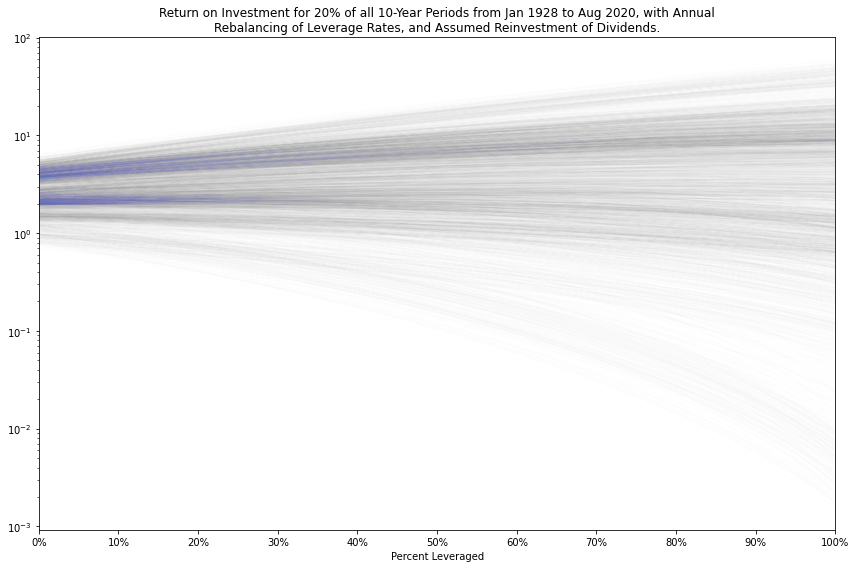

In [23]:
%%time
plt.figure(figsize=(12, 8))
for i in range(0, n_arrays, 5):
    plt.plot(lev, results3[i], alpha=0.005, color='#1f77b4')
    
plt.yscale('log')
plt.xticks(lev[::4], ['{:.0%}'.format(p) for p in lev[::4]])
plt.xlim(0, 1)
plt.xlabel('Percent Leveraged')
plt.title('Return on Investment for 20% of all {}-Year Periods from Jan 1928 to Aug 2020, with Annual\n\
Rebalancing of Leverage Rates, and Assumed Reinvestment of Dividends.'.format(num_years))
plt.tight_layout();
plt.savefig('plots/leverage-{}yr-many_lev_curves.png'.format(num_years), dpi=300);

### Plotting leverage curves by percentile

It should be noted that these quantiles/percentiles are for each leverage rate individually (down `axis=0`). Therefore, a quantile for x% leverage could be from a different n-year period than a quantile for y% leverage. Getting the quantiles for each leverage rate is not quite the same as getting the x% best year for the S&P 500 in general, and then looking at the different leverage rates. Although it's mostly what we're getting because it's the leverage rates tend to move together - as can somewhat be seen in the above plot. There are philosophical advantages to looking at each leverage rate individually, but it means you cannot safely compare horizontally. We do this later in the percentiles based on the S&P 500 performance. 

In [24]:
quantiles = np.linspace(0, 1, 101, endpoint=True)
results3q = np.quantile(results3, quantiles, axis=0)

scheme = sns.color_palette('viridis', quantiles.size)

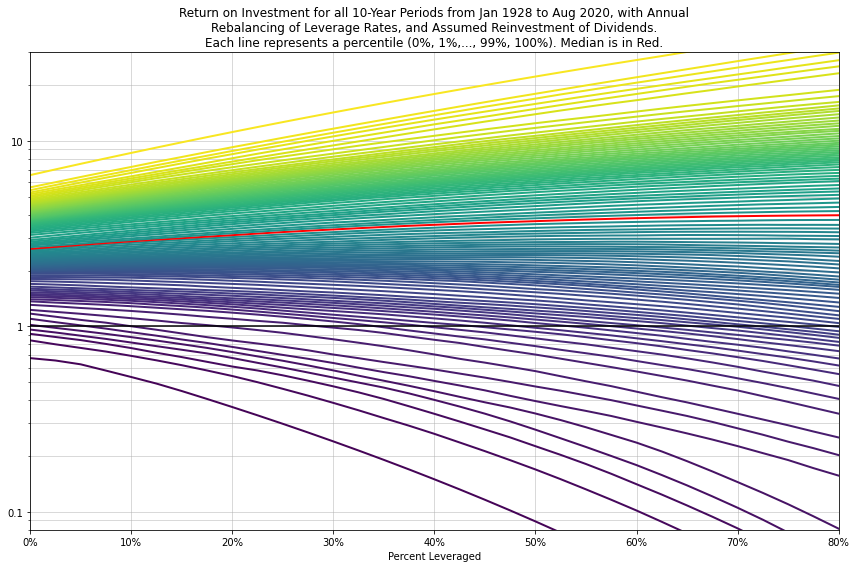

In [25]:
plt.figure(figsize=(12, 8))
for i, quant in enumerate(quantiles):
    results3q[i]
    color = scheme[i]
    label = None
    if quant == 0.5:
        color = 'r'
        label = 'Median'
    plt.plot(lev, results3q[i], 
             color=color, label=label, linewidth=2)
    
plt.yscale('log')
plt.xticks(lev[::4], ['{:.0%}'.format(p) for p in lev[::4]])
plt.axhline(y=1, color='k')
plt.xlim(0, 0.8)
plt.ylim(.08, 30)
plt.yticks([0.1, 1, 10], [0.1, 1, 10])
plt.xlabel('Percent Leveraged')
plt.grid(alpha=0.6, which='both')
plt.title('Return on Investment for all {}-Year Periods from Jan 1928 to Aug 2020, with Annual\n\
Rebalancing of Leverage Rates, and Assumed Reinvestment of Dividends.\n\
Each line represents a percentile (0%, 1%,..., 99%, 100%). Median is in Red.'.format(num_years))
plt.tight_layout();
plt.savefig('plots/leverage-{}yr-percentiles.png'.format(num_years), dpi=300);

In [26]:
relative3q = np.quantile(relative3, quantiles, axis=0)

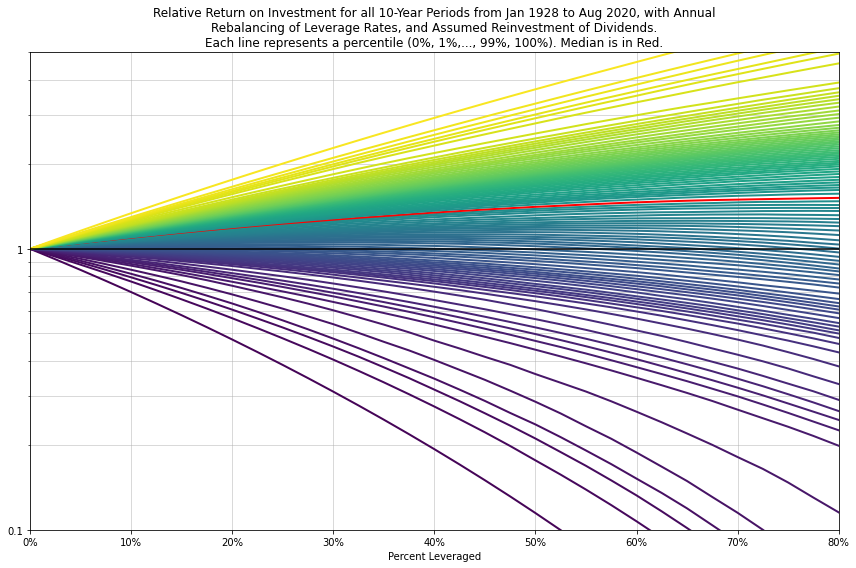

In [27]:
plt.figure(figsize=(12, 8))
for i, quant in enumerate(quantiles):
    relative3q[i]
    color = scheme[i]
    label = None
    if quant == 0.5:
        color = 'r'
        label = 'Median'
    plt.plot(lev, relative3q[i], 
             color=color, label=label, linewidth=2)
    
plt.yscale('log')
plt.xticks(lev[::4], ['{:.0%}'.format(p) for p in lev[::4]])
plt.axhline(y=1, color='k')
plt.xlim(0, 0.8)
plt.ylim(.1, 5)
plt.yticks([0.1, 1], [0.1, 1])
plt.xlabel('Percent Leveraged')
plt.grid(alpha=0.6, which='both')
plt.title('Relative Return on Investment for all {}-Year Periods from Jan 1928 to Aug 2020, with Annual\n\
Rebalancing of Leverage Rates, and Assumed Reinvestment of Dividends.\n\
Each line represents a percentile (0%, 1%,..., 99%, 100%). Median is in Red.'.format(num_years))
plt.tight_layout();
plt.savefig('plots/leverage-{}yr-relative-percentiles.png'.format(num_years), dpi=300);

#### Limited quantiles

In [28]:
quantiles2 = np.array([0.05, 0.15, 0.25, 0.4, 0.6, 0.75, 0.85, 0.95])[::-1]
scheme2 = sns.color_palette('viridis', quantiles2.size)[::-1]

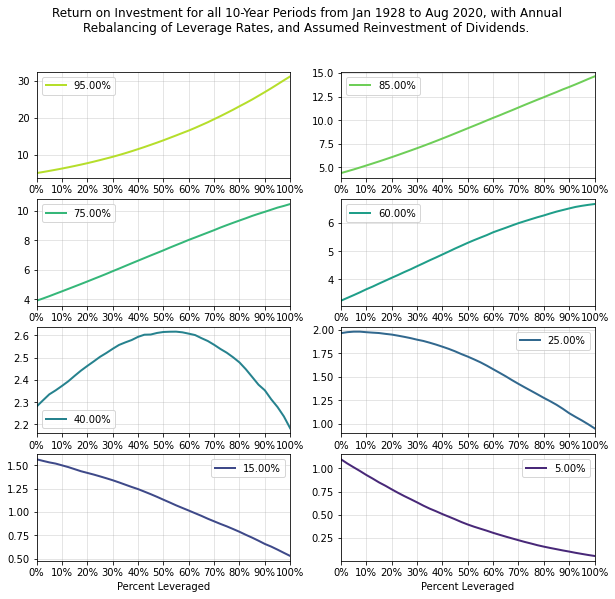

In [29]:
fig, ax = plt.subplots(4, 2, figsize=(10, 9))

for i, quant in enumerate(quantiles2):
    cur_ax = ax.ravel()[i]
    q_array = np.quantile(results3, quant, axis=0)
    color = scheme2[i]
    cur_ax.plot(lev, q_array, 
             color=color, label='{:.2%}'.format(quant), linewidth=2)
    
    cur_ax.set_xticks(lev[::4])
    cur_ax.set_xticklabels(['{:.0%}'.format(p) for p in lev[::4]])
    cur_ax.set_xlim(0, 1)
    cur_ax.grid(alpha=0.4)
    cur_ax.set_xlabel('Percent Leveraged')
    cur_ax.legend()
    
fig.suptitle('Return on Investment for all {}-Year Periods from Jan 1928 to Aug 2020, with Annual\n\
Rebalancing of Leverage Rates, and Assumed Reinvestment of Dividends.'.format(num_years))

plt.savefig('plots/leverage-{}yr-limited_percentiles.png'.format(num_years), dpi=300);

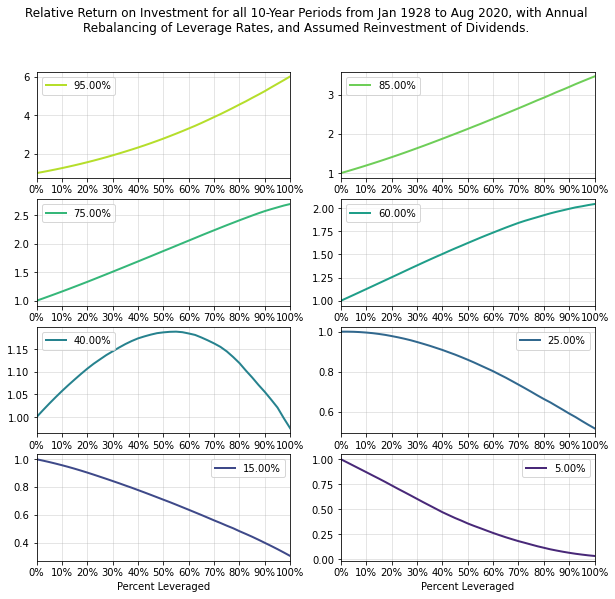

In [30]:
fig, ax = plt.subplots(4, 2, figsize=(10, 9))

for i, quant in enumerate(quantiles2):
    cur_ax = ax.ravel()[i]
    q_array = np.quantile(relative3, quant, axis=0)
    color = scheme2[i]
    cur_ax.plot(lev, q_array, 
             color=color, label='{:.2%}'.format(quant), linewidth=2)
    
    cur_ax.set_xticks(lev[::4])
    cur_ax.set_xticklabels(['{:.0%}'.format(p) for p in lev[::4]])
    cur_ax.set_xlim(0, 1)
    cur_ax.grid(alpha=0.4)
    cur_ax.set_xlabel('Percent Leveraged')
    cur_ax.legend()
    
fig.suptitle('Relative Return on Investment for all {}-Year Periods from Jan 1928 to Aug 2020, with Annual\n\
Rebalancing of Leverage Rates, and Assumed Reinvestment of Dividends.'.format(num_years))

plt.savefig('plots/leverage-{}yr-relative-limited_percentiles.png'.format(num_years), dpi=300);

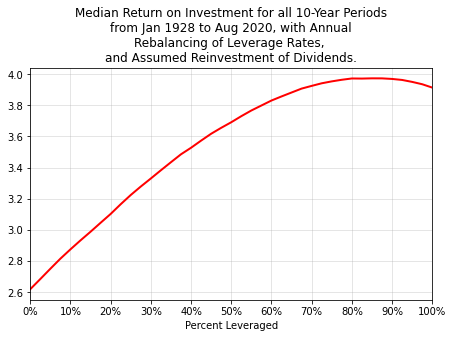

In [31]:
plt.figure(figsize=(6.4, 4.8))
q = 0.5
q_array = np.quantile(results3, q, axis=0)
plt.plot(lev, q_array, color='r', linewidth=2)
    
plt.xticks(lev[::4], ['{:.0%}'.format(p) for p in lev[::4]])
plt.xlim(0, 1)

plt.xlabel('Percent Leveraged')
plt.grid(alpha=0.4)
plt.title('Median Return on Investment for all {}-Year Periods\n\
from Jan 1928 to Aug 2020, with Annual\n\
Rebalancing of Leverage Rates, \n\
and Assumed Reinvestment of Dividends.'.format(num_years));
plt.tight_layout();
plt.savefig('plots/leverage-{}yr-median.png'.format(num_years), dpi=300);

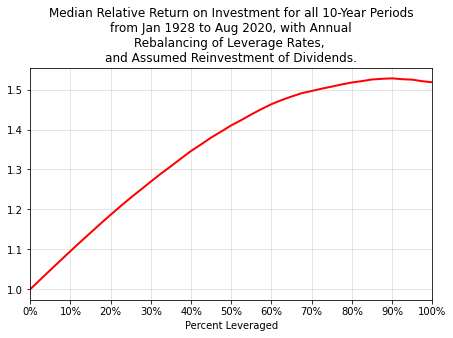

In [32]:
plt.figure(figsize=(6.4, 4.8))
q = 0.5
q_array = np.quantile(relative3, q, axis=0)
plt.plot(lev, q_array, color='r', linewidth=2)
    
plt.xticks(lev[::4], ['{:.0%}'.format(p) for p in lev[::4]])
plt.xlim(0, 1)

plt.xlabel('Percent Leveraged')
plt.grid(alpha=0.4)
plt.title('Median Relative Return on Investment for all {}-Year Periods\n\
from Jan 1928 to Aug 2020, with Annual\n\
Rebalancing of Leverage Rates, \n\
and Assumed Reinvestment of Dividends.'.format(num_years));
plt.tight_layout();
plt.savefig('plots/leverage-{}yr-relative-median.png'.format(num_years), dpi=300);

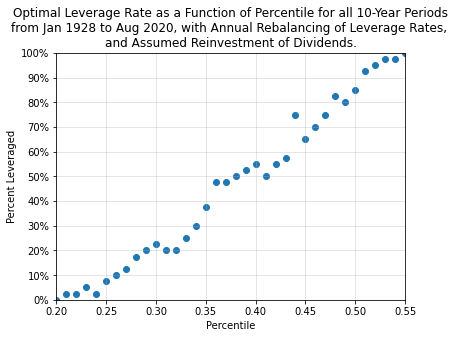

In [33]:
plt.figure(figsize=(6.4, 4.8))
plt.scatter(quantiles, lev[np.argmax(results3q, axis=1)])

plt.yticks(lev[::4], ['{:.0%}'.format(p) for p in lev[::4]])
plt.ylabel('Percent Leveraged')

plt.xlim(0.2, 0.55)
plt.xlabel('Percentile')

plt.grid(alpha=.4)
plt.ylim(0, 1)

plt.title('Optimal Leverage Rate as a Function of Percentile for all {}-Year Periods\n\
from Jan 1928 to Aug 2020, with Annual Rebalancing of Leverage Rates, \n\
and Assumed Reinvestment of Dividends.'.format(num_years))

plt.tight_layout();
plt.savefig('plots/leverage-{}yr-optimal_leverage.png'.format(num_years), dpi=300);

In 80% of 10-year periods, some amount of leverage was better than none.

### Returns by date

In [34]:
lev_plot = np.array([0, 0.25, 0.5, 0.75, 1])

scheme3 = sns.color_palette('viridis_r', lev_plot.size)[::-1]

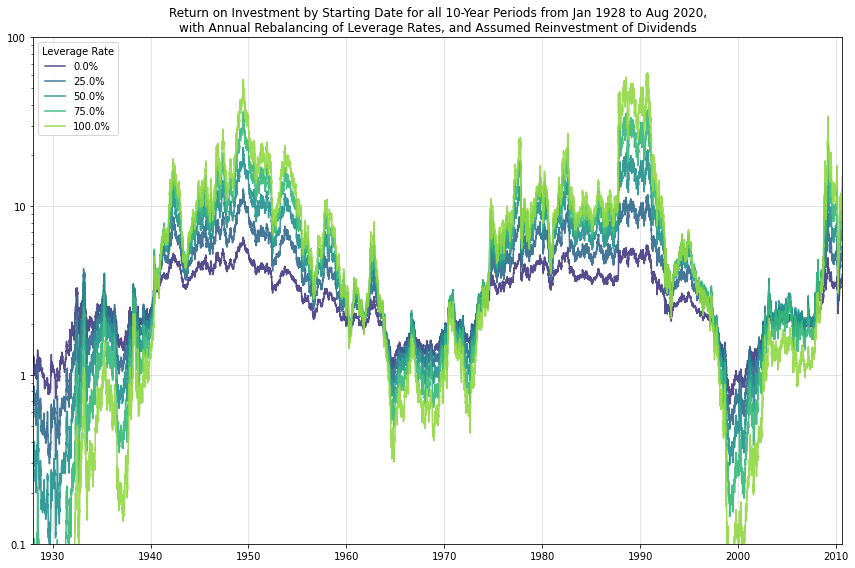

In [35]:
plt.figure(figsize=(12, 8))
for idx, lev_rate in enumerate(lev_plot):
    i = np.where(lev == lev_rate)[0][0]
    plt.plot(start_dates, results3[:,i], label='{:.1%}'.format(lev_rate), 
             color=scheme3[idx], alpha=0.9, linewidth=1.5)
plt.yscale('log')
plt.grid(alpha=0.4)
plt.ylim(0.1, 100)
plt.yticks([0.1, 1, 10, 100], [0.1, 1, 10, 100])
plt.xlim(start_dates[0], start_dates[n_arrays-1])
    
plt.title('Return on Investment by Starting Date for all {}-Year Periods from Jan 1928 to Aug 2020,\n\
with Annual Rebalancing of Leverage Rates, and Assumed Reinvestment of Dividends'.format(num_years))

plt.legend(title='Leverage Rate')
plt.tight_layout();
plt.savefig('plots/leverage-{}yr-returns_by_date.png'.format(num_years), dpi=300);

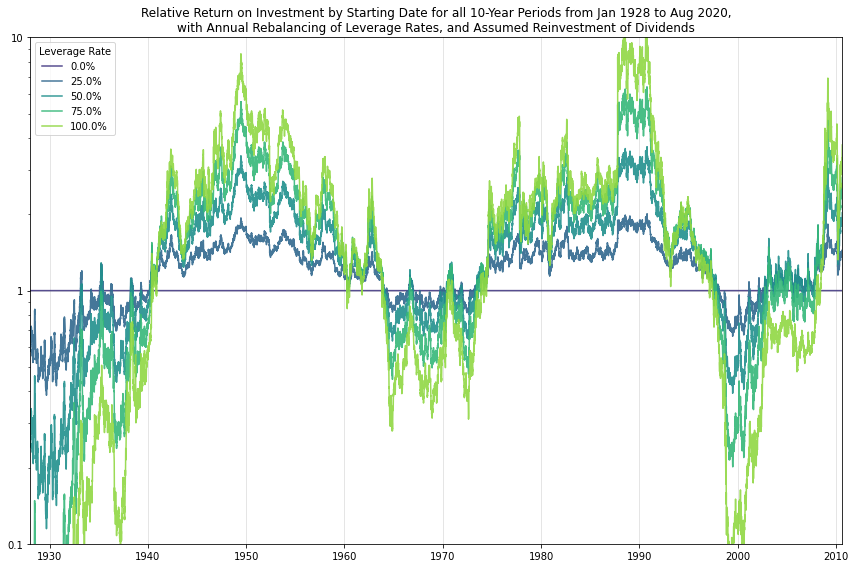

In [36]:
plt.figure(figsize=(12, 8))
for idx, lev_rate in enumerate(lev_plot):
    i = np.where(lev == lev_rate)[0][0]
    plt.plot(start_dates, results3[:,i] / results3[:,0], label='{:.1%}'.format(lev_rate), 
             color=scheme3[idx], alpha=0.9, linewidth=1.5)
plt.yscale('log')
plt.grid(alpha=0.4)
plt.xlim(start_dates[0], start_dates[n_arrays-1])
plt.ylim(0.1, 10)
plt.yticks([0.1, 1, 10], [0.1, 1, 10])
# plt.yticks([0.1, 1, 10, 100], [0.1, 1, 10, 100])
plt.title('Relative Return on Investment by Starting Date for all {}-Year Periods from Jan 1928 to Aug 2020,\n\
with Annual Rebalancing of Leverage Rates, and Assumed Reinvestment of Dividends'.format(num_years))

plt.legend(title='Leverage Rate')
plt.tight_layout();
plt.savefig('plots/leverage-{}yr-relative-returns_by_date.png'.format(num_years), dpi=300);

### Percentiles by S&P 500 performance

So now we can safely compare horizontally. 

In [37]:
sort3 = results3[np.argsort(results3[:,0])]

In [38]:
quantiles2 = np.array([0.05, 0.15, 0.25, 0.4, 0.6, 0.75, 0.85, 0.95])[::-1]
scheme2 = sns.color_palette('viridis', quantiles2.size)[::-1]

qidxs = np.floor(n_arrays * quantiles2).astype(np.intp)

sortq3 = sort3[qidxs]

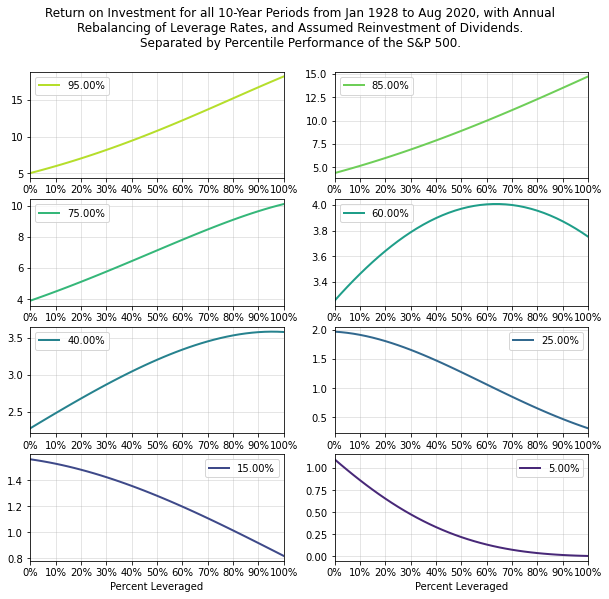

In [39]:
fig, ax = plt.subplots(4, 2, figsize=(10, 9))

for i, quant in enumerate(quantiles2):
    cur_ax = ax.ravel()[i]
    q_array = sortq3[i]
    color = scheme2[i]
    cur_ax.plot(lev, q_array, 
             color=color, label='{:.2%}'.format(quant), linewidth=2)
    
    cur_ax.set_xticks(lev[::4])
    cur_ax.set_xticklabels(['{:.0%}'.format(p) for p in lev[::4]])
    cur_ax.set_xlim(0, 1)
    cur_ax.grid(alpha=0.4)
    cur_ax.set_xlabel('Percent Leveraged')
    cur_ax.legend()
    
fig.suptitle('Return on Investment for all {}-Year Periods from Jan 1928 to Aug 2020, with Annual\n\
Rebalancing of Leverage Rates, and Assumed Reinvestment of Dividends.\n\
Separated by Percentile Performance of the S&P 500.'.format(num_years));

plt.savefig('plots/leverage-{}yr-basis-limited_percentiles.png'.format(num_years), dpi=300);

In [40]:
relative_sortq3 = sortq3 / sortq3[:,0].reshape(quantiles2.size, -1)

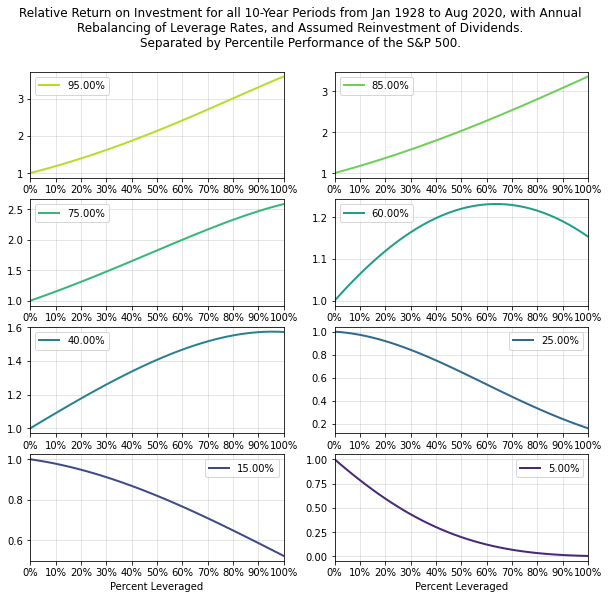

In [41]:
fig, ax = plt.subplots(4, 2, figsize=(10, 9))

for i, quant in enumerate(quantiles2):
    cur_ax = ax.ravel()[i]
    q_array = relative_sortq3[i]
    color = scheme2[i]
    cur_ax.plot(lev, q_array, 
             color=color, label='{:.2%}'.format(quant), linewidth=2)
    
    cur_ax.set_xticks(lev[::4])
    cur_ax.set_xticklabels(['{:.0%}'.format(p) for p in lev[::4]])
    cur_ax.set_xlim(0, 1)
    cur_ax.grid(alpha=0.4)
    cur_ax.set_xlabel('Percent Leveraged')
    cur_ax.legend()
    
fig.suptitle('Relative Return on Investment for all {}-Year Periods from Jan 1928 to Aug 2020, with Annual\n\
Rebalancing of Leverage Rates, and Assumed Reinvestment of Dividends.\n\
Separated by Percentile Performance of the S&P 500.'.format(num_years));

plt.savefig('plots/leverage-{}yr-relative-basis-limited_percentiles.png'.format(num_years), dpi=300);

### Compare histograms of 0% and 50% leveraged.

In [42]:
idx50 = 20
lev[idx50]

0.5

In [43]:
print(np.quantile(results3[:,0], 0.5), np.quantile(results3[:,idx50], 0.5))

2.6187850357727385 3.691349638668001


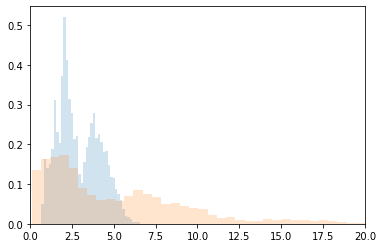

In [44]:
plt.hist(results3[:,0], bins=40, alpha=0.2, density=True)

plt.hist(results3[:,idx50], 
         bins=40, alpha=0.2, density=True)
plt.xlim(0, 20);

### What were some of the craziest n-year returns, and when were they?

#### Maximum returns

In [45]:
maximums = np.unique(np.argmax(results3, axis=0))

In [46]:
# 0% leverage, 100% leverage
results3[maximums][:,0], results3[maximums][:,-1]

(array([6.53838369, 6.52904942, 5.87524872, 5.85295388]),
 array([56.35101747, 56.13731211, 61.59153059, 61.39167115]))

In [47]:
start_dates[maximums]

DatetimeIndex(['1949-06-14', '1949-06-20', '1990-09-25', '1990-10-12'], dtype='datetime64[ns]', name='Date', freq=None)

#### Minimum returns

In [48]:
minimums = np.unique(np.argmin(results3, axis=0))

In [49]:
# 0% leverage, 100% leverage
results3[minimums][:,0], results3[minimums][:,-1]

(array([0.77400763, 0.77237116, 0.77301173, 0.725557  , 0.6740997 ]),
 array([0.00157634, 0.00156529, 0.00156317, 0.00184107, 0.04369578]))

In [50]:
start_dates[minimums]

DatetimeIndex(['1929-09-03', '1929-09-04', '1929-09-05', '1930-04-21',
               '1999-02-24'],
              dtype='datetime64[ns]', name='Date', freq=None)